In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from numpy import mean
import warnings

In [2]:
# Preprocessing function
def pre_process(subject):
    # The list of columns to be dropped
    drop_ls = [
        "expected_time",
        "flip_time",
        "stim_pos",
        "user_pos",
        "lambda_val",
        "change_rate_x",
    ]
    # The feature matrix in array form
    X = subject.drop(columns=drop_ls).to_numpy()

    # Compute the target variable as the difference between user_pos and stim_pos
    y_pos = subject["stim_pos"].to_numpy()
    y = y_pos

    return X, y

# Function to load all CSV files from a folder
def load_subject_data(folder_path):
    data = []
    subject_id = 1  # Start subject ID counter at 1
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):  # Check if the file is a CSV
            file_path = os.path.join(folder_path, file_name)
            subject_data = pd.read_csv(file_path)
            subject_data['subject_id'] = subject_id  # Assign consecutive subject ID
            data.append(subject_data)
            subject_id += 1  # Increment subject ID for the next file
    return pd.concat(data, ignore_index=True)

# Ridge regression with LOOCV across subjects
def loocv_ridge_across_subjects(data, alpha=1.0):
    unique_subjects = data['subject_id'].unique()
    data_nmae = []
    data_r2 = []

    for test_subject in unique_subjects:
        # Split into train and test by subject
        train_data = data[data['subject_id'] != test_subject]
        test_data = data[data['subject_id'] == test_subject]

        # Preprocess the training and testing data
        X_train, y_train = pre_process(train_data)
        X_test, y_test = pre_process(test_data)

        # Ridge regression model
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)

        # Calculate scores
        r2 = r2_score(y_test, y_pred)
        nmae = (-1 * mean_absolute_error(y_test, y_pred))
        data_nmae.append(nmae)
        data_r2.append(r2)

    # Average error across all subjects
    mean_r2 = np.mean(data_r2)
    mean_nmae = np.mean(data_nmae)
    return mean_nmae, data_nmae, mean_r2, data_r2

# Main function
def main_fxn(data_folder_path, data_type):
    # Path to the folder containing the subject files
    folder_path = data_folder_path  # Replace with the path to your folder
    alpha = 0.01  # Regularization parameter for Ridge regression

    # Load data from all CSV files in the folder
    data = load_subject_data(folder_path)

    # Ensure required columns exist in the dataset
    required_columns = [
        "expected_time",
        "flip_time",
        "stim_pos",
        "user_pos",
        "lambda_val",
        "change_rate_x",
    ]
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Missing one or more required columns: {required_columns}")

    # Perform LOOCV across subjects
    mean_nmae, data_nmae, mean_r2, data_r2 = loocv_ridge_across_subjects(data, alpha)

    # Print results
    print(f"Mean R2 across subjects for {data_type}: {mean_r2}")
    print(f"Individual subject R2 Values for {data_type}: {data_r2}")
    print(f"Mean NMAE across subjects for {data_type}: {mean_nmae}")
    print(f"Individual subject NMAE Values for {data_type}: {data_nmae}")

    return mean_nmae, data_nmae, mean_r2, data_r2

In [3]:
DIRECTORY = 'hopkins_export/'  # Adjust this path as needed
MM_DIRECTORY = 'minmax_subjects/'
ZS_DIRECTORY = 'zscore_subjects/'
RS_DIRECTORY = 'robust_subjects/'
raw_mean_nmae, raw_data_nmae, raw_mean_r2, raw_data_r2 = main_fxn(DIRECTORY, 'Raw Data')
mm_mean_nmae, mm_data_nmae, mm_mean_r2, mm_data_r2 = main_fxn(MM_DIRECTORY, 'Min-Max Normalization')
zs_mean_nmae, zs_data_nmae, zs_mean_r2, zs_data_r2 = main_fxn(ZS_DIRECTORY, 'Z-Score Normalization')
rs_mean_nmae, rs_data_nmae, rs_mean_r2, rs_data_r2 = main_fxn(RS_DIRECTORY, 'Robust Scaling Normalization')

Mean R2 across subjects for Raw Data: -0.0635085432238202
Individual subject R2 Values for Raw Data: [0.0006828052526967054, -0.028931994397842775, -0.01535325205663951, -0.18634735659412138, -0.09156215063849715, -0.18880244672889512, -8.911950808676572e-05, -0.05663256774994263, -0.036994775138101454, -0.2722341184142305, -0.05086864800619373, -0.00967372702361935, -0.012743984419364862, -0.01182750246922204, -0.0027038564515782237, -0.04900681873064183, -0.17801790236789072, -0.0640639779140042, -0.02512684704494461, -0.03701151408138048, -0.023435792973854452, -0.02149397826412236, -0.3994233178149549, -0.314869760646866, -0.0050649135203246765, -0.0026742113515279, -0.08008303580857179, -0.003798686798970108, -0.18289564683232307, -0.02691729719612579, -0.08384074045493595, -0.007256557695808352, -0.17805037879034114, -0.02708813915932562, -0.022243224538102346, -0.016597353647010538, -0.06496158181007172, -0.007384897664222567, -0.08885075511115881, -0.03522453536472048, -0.00463

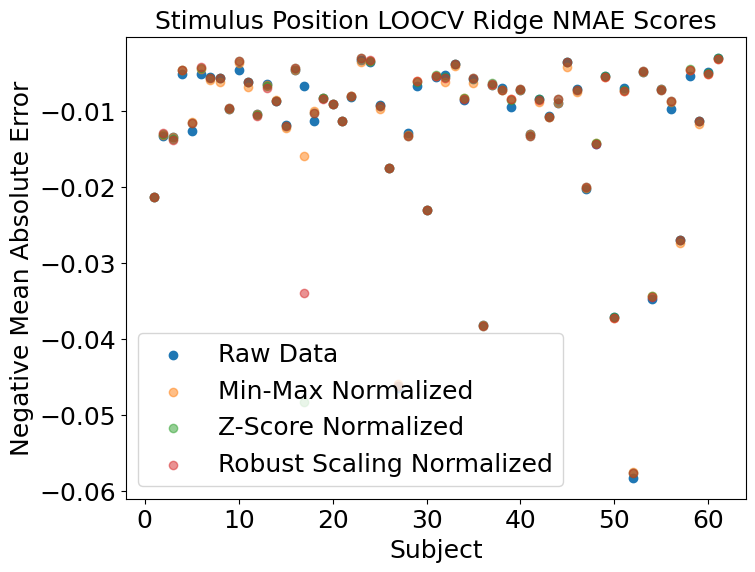

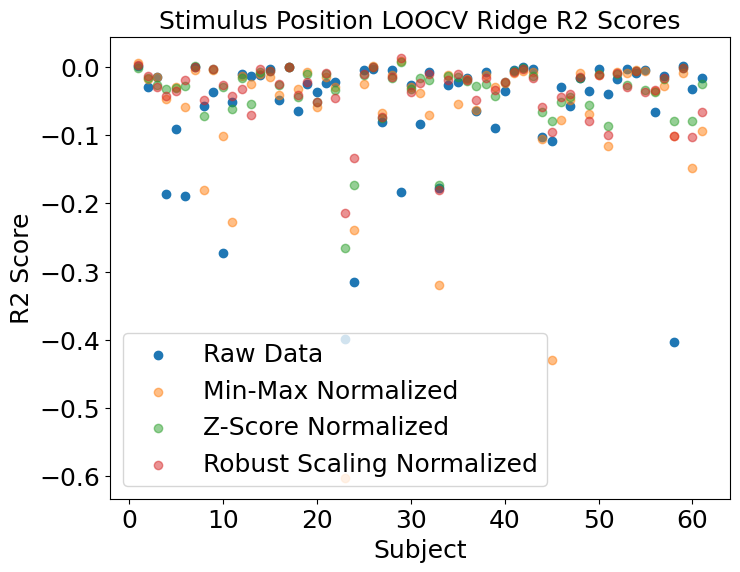

In [7]:
x = np.linspace(1,61,61, dtype = int)

raw_data_r2[16] = 0
zs_data_r2[16] = 0
rs_data_r2[16] = 0
mm_data_r2[16] = 0

plt.figure(figsize=(8,6))
plt.scatter(x, raw_data_nmae, label = 'Raw Data')
plt.scatter(x, mm_data_nmae, label = 'Min-Max Normalized', alpha = 0.5)
plt.scatter(x, zs_data_nmae, label = 'Z-Score Normalized', alpha = 0.5)
plt.scatter(x, rs_data_nmae, label = 'Robust Scaling Normalized', alpha = 0.5)
plt.xlabel('Subject', fontsize = 18)
plt.ylabel('Negative Mean Absolute Error', fontsize = 18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Stimulus Position LOOCV Ridge NMAE Scores', fontsize = 18)
plt.legend(fontsize = 18)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(x, raw_data_r2, label = 'Raw Data')
plt.scatter(x, mm_data_r2, label = 'Min-Max Normalized', alpha = 0.5)
plt.scatter(x, zs_data_r2, label = 'Z-Score Normalized', alpha = 0.5)
plt.scatter(x, rs_data_r2, label = 'Robust Scaling Normalized', alpha = 0.5)
plt.xlabel('Subject', fontsize = 18)
plt.ylabel('R2 Score', fontsize = 18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Stimulus Position LOOCV Ridge R2 Scores', fontsize = 18)
plt.legend(fontsize = 18)
plt.show()

In [5]:
zs_data_r2

[-0.000884490521002812,
 -0.016844356432664576,
 -0.027074956731937272,
 -0.03197683356968439,
 -0.03105199813293047,
 -0.02835463636867619,
 0.0009331180244659398,
 -0.07147138708313583,
 -0.0037081145451500763,
 -0.029065526066955227,
 -0.06148379843973162,
 -0.015604250611093828,
 -0.05388487959923283,
 -0.006832605503268807,
 -0.00597652220844247,
 -0.02676654867666861,
 0,
 -0.04437709223460651,
 -0.01072006117400548,
 -0.051477741480346895,
 -0.010117374716499095,
 -0.03421224124432021,
 -0.265165923730007,
 -0.17265247609453227,
 -0.01155200702868231,
 -0.00021523329435235716,
 -0.07438790331376044,
 -0.01558610723246412,
 0.007580519714342593,
 -0.03302291835624005,
 -0.01641416471380741,
 -0.01855544707795609,
 -0.17370387908583274,
 -0.013954218886949477,
 -0.014798413466351912,
 -0.020038646042603414,
 -0.028270699758558893,
 -0.02557300586790312,
 -0.04203518424795116,
 -0.02238533396556841,
 -0.005907343110396868,
 -0.0019447681913529191,
 -0.012588966461605011,
 -0.065893